# Random Forest Classifier Model 2
## With data engineering on missing values in 'Critic_Score' column
The missing values in 'Critic_Score' column are substituted with the average critic score values that is generated by grouping the data by their 'Developer_x' and retrieving each group's average score.

### Objective
Predict the class of total sales (low, medium, high) based on different features

### Input Data
This script will try 2 input datasets, with and without 'Country' column to increase number of input rows. Both input datasets include 'Critic_Score' column.
1. Dataframe 1: With 'Country' column
2. Dataframe 2: No 'Country' column

### Create Additional 'Total_Sales_Class' column
The Total_Sales is categorized into 3 classes: low, medium, high. 
<br>Based on the number of total sales where the average is around 0.5 milliions, the binning is as follow:
- Low: total sales < 1 millions
- Medium: total sales higher than 1 millions and less than 10 millions
- High: total sales > 10 millions

### Target Variable and Features
- Target variable (y) = Total_Sales_Class (low, medium, high)
- X = Critic_Score, Genre, ESRB_Rating, Platform, Publisher, Developer_x, Country

### Machine Learning Models
- rf_model = RandomForestClassifier
- brf_model = BalancedRandomForestClassifier
- eec_model = EasyEnsembleClassifier


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [77]:
# Load the dataset from AWS S3 bucket
#games_df = pd.read_csv('https://video-game-dataset-uot-boot-camp-2022-group-4.s3.us-east-2.amazonaws.com/all_columns_df.csv')
games_df = pd.read_csv('Cleaned_Data/all_columns_df.csv')
games_df

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales
0,1,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006.0,Japan,82.86
1,2,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985.0,Japan,40.24
2,3,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008.0,Japan,37.14
3,4,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017.0,NaN,36.60
4,5,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009.0,Japan,33.09
...,...,...,...,...,...,...,...,...,...,...,...,...
19857,19858,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004.0,NaN,0.01
19858,19859,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003.0,Europe,0.01
19859,19860,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002.0,Japan,0.01
19860,19861,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017.0,NaN,0.01


In [78]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19862 entries, 0 to 19861
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          19862 non-null  int64  
 1   Name          19862 non-null  object 
 2   Genre         19862 non-null  object 
 3   ESRB_Rating   13925 non-null  object 
 4   Platform      19862 non-null  object 
 5   Publisher     19862 non-null  object 
 6   Developer_x   19860 non-null  object 
 7   Critic_Score  4706 non-null   float64
 8   User_Score    238 non-null    float64
 9   Year          19859 non-null  float64
 10  Country       11877 non-null  object 
 11  Total_Sales   19862 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.8+ MB


In [79]:
# Change 'Year' dtype to object
games_df['Year'] = pd.to_datetime(games_df['Year'], format = '%Y').dt.strftime('%Y')

In [80]:
# Drop columns that won't be included in the analysis
games_df.drop(['Rank'], axis = 1, inplace = True)
games_df

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales
0,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006,Japan,82.86
1,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985,Japan,40.24
2,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008,Japan,37.14
3,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017,NaN,36.60
4,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009,Japan,33.09
...,...,...,...,...,...,...,...,...,...,...,...
19857,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004,NaN,0.01
19858,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003,Europe,0.01
19859,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002,Japan,0.01
19860,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017,NaN,0.01


In [81]:
# Sattistics of the Total_Sales column
games_df.describe()

,Critic_Score,User_Score,Total_Sales
count,4706.000000,238.000000,19862.000000
mean,7.269911,8.465546,0.530876
std,1.420956,1.215681,1.572634
min,1.000000,2.000000,0.010000
25%,6.500000,8.000000,0.050000
50%,7.500000,8.800000,0.160000
75%,8.300000,9.300000,0.450000
max,10.000000,10.000000,82.860000


## Substitute the missing values in 'Critic_Score' column

In [82]:
a = games_df.groupby(['Developer_x'])['Critic_Score'].mean().to_dict()
games_df['Critic_Score1'] = games_df.Developer_x.map(a)

In [83]:
# Create another column for new critic score where the NaNs are substituted with avg critic score grouped by developer
games_df['Critic_Score_new'] = np.where(games_df.Critic_Score.isna() == True, games_df.Critic_Score1, games_df.Critic_Score)
games_df

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score,User_Score,Year,Country,Total_Sales,Critic_Score1,Critic_Score_new
0,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,2006,Japan,82.86,8.379412,7.700000
1,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,1985,Japan,40.24,8.379412,10.000000
2,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,2008,Japan,37.14,8.379412,8.200000
3,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,2017,NaN,36.60,NaN,NaN
4,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,2009,Japan,33.09,8.379412,8.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19857,FirePower for Microsoft Combat Flight Simulator 3,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,NaN,2004,NaN,0.01,NaN,NaN
19858,Tom Clancy's Splinter Cell,Shooter,T,PC,Ubisoft,Ubisoft,NaN,NaN,2003,Europe,0.01,6.606977,6.606977
19859,Ashita no Joe 2: The Anime Super Remix,Fighting,NaN,PS2,Capcom,Capcom,NaN,NaN,2002,Japan,0.01,7.763810,7.763810
19860,Tokyo Yamanote Boys for V: Main Disc,Adventure,NaN,PSV,Rejet,Rejet,NaN,NaN,2017,NaN,0.01,NaN,NaN


In [84]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19862 entries, 0 to 19861
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              19862 non-null  object 
 1   Genre             19862 non-null  object 
 2   ESRB_Rating       13925 non-null  object 
 3   Platform          19862 non-null  object 
 4   Publisher         19862 non-null  object 
 5   Developer_x       19860 non-null  object 
 6   Critic_Score      4706 non-null   float64
 7   User_Score        238 non-null    float64
 8   Year              19859 non-null  object 
 9   Country           11877 non-null  object 
 10  Total_Sales       19862 non-null  float64
 11  Critic_Score1     15044 non-null  float64
 12  Critic_Score_new  15044 non-null  float64
dtypes: float64(5), object(8)
memory usage: 2.0+ MB


In [85]:
# Drop Critic_Score Critic_Score3 and columns
games_df.drop(['Critic_Score', 'Critic_Score1'], axis=1, inplace=True)

In [86]:
games_df.head()

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,User_Score,Year,Country,Total_Sales,Critic_Score_new
0,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,2006,Japan,82.86,7.7
1,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,1985,Japan,40.24,10.0
2,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,9.1,2008,Japan,37.14,8.2
3,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,2017,NaN,36.60,NaN
4,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.8,2009,Japan,33.09,8.0


## Bin Total_Sales and Create 'Total_Sales_Class' column

In [87]:
# Create bin for 'Total_Sales' column
bins = [0,1,10,100]
labels = ['low', 'medium', 'high']

In [88]:
# Bin 'Total_Sales' into new column
games_df['Total_Sales_Class'] = pd.cut(games_df['Total_Sales'], bins=bins, labels=labels, right=False)
games_df.head(10)

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer_x,User_Score,Year,Country,Total_Sales,Critic_Score_new,Total_Sales_Class
0,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,2006,Japan,82.86,7.7,high
1,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,1985,Japan,40.24,10.0,high
2,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,9.1,2008,Japan,37.14,8.2,high
3,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,2017,NaN,36.60,NaN,high
4,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.8,2009,Japan,33.09,8.0,high
5,Pokemon Red / Green / Blue Version,Role-Playing,E,GB,Nintendo,Game Freak,NaN,1998,Japan,31.38,9.4,high
6,New Super Mario Bros.,Platform,E,DS,Nintendo,Nintendo EAD,8.1,2006,Japan,30.80,9.1,high
7,Tetris,Puzzle,E,GB,Nintendo,Bullet Proof Software,NaN,1989,Japan,30.26,NaN,high
8,New Super Mario Bros. Wii,Platform,E,Wii,Nintendo,Nintendo EAD,9.2,2009,Japan,30.22,8.6,high
9,Minecraft,Misc,NaN,PC,Mojang,Mojang AB,NaN,2010,NaN,30.01,10.0,high


In [89]:
games_df.Total_Sales_Class.value_counts()

low       17420
medium     2355
high         87
Name: Total_Sales_Class, dtype: int64

In [90]:
# Dropping unnecessary columns
games_df.drop(['Name','User_Score','Year'], axis=1, inplace=True)
games_df

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Country,Total_Sales,Critic_Score_new,Total_Sales_Class
0,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,82.86,7.700000,high
1,Platform,NaN,NES,Nintendo,Nintendo EAD,Japan,40.24,10.000000,high
2,Racing,E,Wii,Nintendo,Nintendo EAD,Japan,37.14,8.200000,high
3,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,36.60,NaN,high
4,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,33.09,8.000000,high
...,...,...,...,...,...,...,...,...,...
19857,Simulation,T,PC,GMX Media,Shockwave Productions,NaN,0.01,NaN,low
19858,Shooter,T,PC,Ubisoft,Ubisoft,Europe,0.01,6.606977,low
19859,Fighting,NaN,PS2,Capcom,Capcom,Japan,0.01,7.763810,low
19860,Adventure,NaN,PSV,Rejet,Rejet,NaN,0.01,NaN,low


In [91]:
games_df.count()

Genre                19862
ESRB_Rating          13925
Platform             19862
Publisher            19862
Developer_x          19860
Country              11877
Total_Sales          19862
Critic_Score_new     15044
Total_Sales_Class    19862
dtype: int64

## Checking NaNs

In [92]:
# To see the row count if drop NaN in all columns
games_df.dropna().count()

Genre                8306
ESRB_Rating          8306
Platform             8306
Publisher            8306
Developer_x          8306
Country              8306
Total_Sales          8306
Critic_Score_new     8306
Total_Sales_Class    8306
dtype: int64

# Dataframe 1: with 'Critic_Score' column

In [93]:
# Drop all NaNs values
no_nan_df = games_df.drop(['Total_Sales'], axis=1).dropna()
print(no_nan_df.shape)
no_nan_df.head()

(8306, 8)


,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Country,Critic_Score_new,Total_Sales_Class
0,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,7.7,high
2,Racing,E,Wii,Nintendo,Nintendo EAD,Japan,8.2,high
4,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,8.0,high
5,Role-Playing,E,GB,Nintendo,Game Freak,Japan,9.4,high
6,Platform,E,DS,Nintendo,Nintendo EAD,Japan,9.1,high


## Bucket data to top 10 and other bins

In [94]:
# Check unique values
no_nan_df.nunique()

Genre                 18
ESRB_Rating            6
Platform              29
Publisher             87
Developer_x          864
Country               15
Critic_Score_new     361
Total_Sales_Class      3
dtype: int64

In [95]:
# Keep top 14 of Genre
top = no_nan_df.Genre.value_counts().index[0:14]
no_nan_df.Genre = np.where(no_nan_df.Genre.isin(top), no_nan_df.Genre,'other')

In [96]:
# Keep top 18 of Platform
top = no_nan_df.Platform.value_counts().index[0:18]
no_nan_df.Platform = np.where(no_nan_df.Platform.isin(top), no_nan_df.Platform,'other')

In [97]:
# Keep top 15 of Publisher
top = no_nan_df.Publisher.value_counts().index[0:15]
no_nan_df.Publisher = np.where(no_nan_df.Publisher.isin(top), no_nan_df.Publisher, 'other')

In [98]:
# Keep top 15 of Developer_x
top = no_nan_df.Developer_x.value_counts().index[0:15]
no_nan_df.Developer_x = np.where(no_nan_df.Developer_x.isin(top), no_nan_df.Developer_x,'other')

In [99]:
no_nan_df

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Country,Critic_Score_new,Total_Sales_Class
0,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,7.700000,high
2,Racing,E,Wii,Nintendo,Nintendo EAD,Japan,8.200000,high
4,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,8.000000,high
5,Role-Playing,E,other,Nintendo,other,Japan,9.400000,high
6,Platform,E,DS,Nintendo,Nintendo EAD,Japan,9.100000,high
...,...,...,...,...,...,...,...,...
19815,Racing,T,XB,Midway Games,other,United States,7.087500,low
19823,Adventure,E10,PC,other,other,United States,6.600000,low
19838,Strategy,T,PC,Sega,other,United States,7.692857,low
19856,Platform,E,3DS,Nintendo,other,Japan,7.200000,low


In [100]:
# Check unique values
no_nan_df.nunique()

Genre                 15
ESRB_Rating            6
Platform              19
Publisher             16
Developer_x           16
Country               15
Critic_Score_new     361
Total_Sales_Class      3
dtype: int64

## Encoding categorical variables

In [101]:
# Assign features
X = no_nan_df.drop('Total_Sales_Class', axis = 1)
X

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Country,Critic_Score_new
0,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,7.700000
2,Racing,E,Wii,Nintendo,Nintendo EAD,Japan,8.200000
4,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,8.000000
5,Role-Playing,E,other,Nintendo,other,Japan,9.400000
6,Platform,E,DS,Nintendo,Nintendo EAD,Japan,9.100000
...,...,...,...,...,...,...,...
19815,Racing,T,XB,Midway Games,other,United States,7.087500
19823,Adventure,E10,PC,other,other,United States,6.600000
19838,Strategy,T,PC,Sega,other,United States,7.692857
19856,Platform,E,3DS,Nintendo,other,Japan,7.200000


In [102]:
X.dtypes

Genre                object
ESRB_Rating          object
Platform             object
Publisher            object
Developer_x          object
Country              object
Critic_Score_new    float64
dtype: object

In [103]:
# Encoding object dtype columns
X_cat = X.select_dtypes(include='object')
X_cat = list(X_cat.columns)
X_cat

['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer_x', 'Country']

In [104]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(X[X_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(X_cat)

encode_df

/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Country_Germany,Country_Italy,Country_Japan,Country_Norway,Country_Poland,Country_Russia,Country_South Korea,Country_Spain,Country_United Kingdom,Country_United States
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8302,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8304,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
# Reset X dataframe index to merge with encode_df
X.reset_index(drop=True, inplace=True)
X

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Country,Critic_Score_new
0,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,7.700000
1,Racing,E,Wii,Nintendo,Nintendo EAD,Japan,8.200000
2,Sports,E,Wii,Nintendo,Nintendo EAD,Japan,8.000000
3,Role-Playing,E,other,Nintendo,other,Japan,9.400000
4,Platform,E,DS,Nintendo,Nintendo EAD,Japan,9.100000
...,...,...,...,...,...,...,...
8301,Racing,T,XB,Midway Games,other,United States,7.087500
8302,Adventure,E10,PC,other,other,United States,6.600000
8303,Strategy,T,PC,Sega,other,United States,7.692857
8304,Platform,E,3DS,Nintendo,other,Japan,7.200000


In [106]:
# Merge one-hot encoded features and drop the originals
X = X.merge(encode_df, left_index=True, right_index=True)
X = X.drop(X_cat,1)
X

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_12611/2670095812.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X.drop(X_cat,1)


,Critic_Score_new,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,...,Country_Germany,Country_Italy,Country_Japan,Country_Norway,Country_Poland,Country_Russia,Country_South Korea,Country_Spain,Country_United Kingdom,Country_United States
0,7.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.100000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8301,7.087500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8302,6.600000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8303,7.692857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8304,7.200000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
# Assign the target
y = no_nan_df['Total_Sales_Class']
y.value_counts()

low       6579
medium    1653
high        74
Name: Total_Sales_Class, dtype: int64

In [108]:
X.shape

(8306, 88)

In [109]:
y.shape

(8306,)

## Spliting and scale the data

In [110]:
# Split data to training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Check the balance of the target variables.
print(f"y_train: {Counter(y_train)}")
print(f"y_test: {Counter(y_test)}")

y_train: Counter({'low': 4915, 'medium': 1252, 'high': 62})
y_test: Counter({'low': 1664, 'medium': 401, 'high': 12})


In [111]:
# Creating a StandardScaler instance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Random Forest Classifier Model

In [112]:
# Create a random forest classifier.
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

In [113]:
# Fitting the model
rf_model_1 = rf_model.fit(X_train_scaled, y_train)
# Making predictions using the testing data.
y_pred_rf = rf_model_1.predict(X_test_scaled)

In [114]:
# Calculating the accuracy score.
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
acc_score = accuracy_score(y_test, y_pred_rf)

In [115]:
cm = confusion_matrix(y_test, y_pred_rf)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

cm_df

,Predicted high,Predicted low,Predicted medium
Actual high,3,3,6
Actual low,2,1552,110
Actual medium,7,236,158


In [116]:
# Displaying results
print('Model: Random Forest Classifier')
print("---------------------")
print(f"Accuracy Score : {acc_score}")
print("---------------------")
print("Classification Report")
print(classification_report(y_test, y_pred_rf))

Model: Random Forest Classifier
---------------------
Accuracy Score : 0.8247472315840154
---------------------
Classification Report
              precision    recall  f1-score   support

        high       0.25      0.25      0.25        12
         low       0.87      0.93      0.90      1664
      medium       0.58      0.39      0.47       401

    accuracy                           0.82      2077
   macro avg       0.56      0.53      0.54      2077
weighted avg       0.81      0.82      0.81      2077



## Rank the importance of features

In [117]:
# Calculate feature importance in the Random Forest model.
print("Feature Importance: rf model 1: all columns")
sorted(zip(rf_model_1.feature_importances_, X.columns), reverse=True)

Feature Importance: rf model 1: all columns


[(0.3567620057105762, 'Critic_Score_new'),
 (0.03378182301771191, 'Publisher_Nintendo'),
 (0.02029198992191842, 'Platform_PS2'),
 (0.01834858137654143, 'Genre_Action'),
 (0.01826419731037142, 'Publisher_other'),
 (0.018231593936079413, 'ESRB_Rating_E'),
 (0.017689180597538764, 'ESRB_Rating_T'),
 (0.01714978732181302, 'Platform_PS3'),
 (0.0163229853150208, 'Platform_X360'),
 (0.015888158123427615, 'Developer_x_other'),
 (0.01530080806843305, 'Genre_Role-Playing'),
 (0.01477782929598176, 'Genre_Sports'),
 (0.014536165602000337, 'ESRB_Rating_M'),
 (0.014475641544622801, 'ESRB_Rating_E10'),
 (0.014178692291081678, 'Genre_Racing'),
 (0.014143046313502949, 'Platform_Wii'),
 (0.014076041341440844, 'Genre_Platform'),
 (0.013884706024789292, 'Genre_Shooter'),
 (0.01377249859022381, 'Platform_PC'),
 (0.013747962866740758, 'Platform_PS4'),
 (0.013525636127666382, 'Platform_PS'),
 (0.012923108826365949, 'Publisher_Electronic Arts'),
 (0.012630535127467982, 'Genre_Misc'),
 (0.011600110053523632, 'G

(0.0, 0.4)

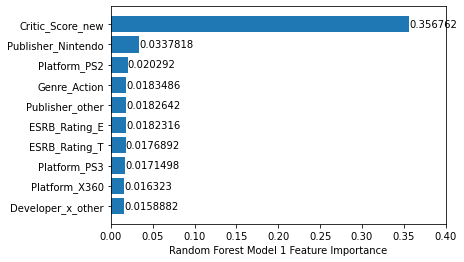

In [118]:
sorted_idx = rf_model_1.feature_importances_.argsort()[-10:]
x = X.columns[sorted_idx]
y = rf_model_1.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Random Forest Model 1 Feature Importance")
plt.xlim(0.0,0.4)

## Balanced Random Forest Classifier Model

In [119]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

brf_model = BalancedRandomForestClassifier(n_estimators=128, random_state = 78) 

# Fitting the model
brf_model_1 = brf_model.fit(X_train, y_train)

In [120]:
# Calculated the balanced accuracy score
y_pred_brf = brf_model_1.predict(X_test)

from sklearn.metrics import balanced_accuracy_score
brf_acc_score = balanced_accuracy_score(y_test, y_pred_brf)

In [121]:
cm_brf = confusion_matrix(y_test, y_pred_brf)

# Create a DataFrame from the confusion matrix.
cm_brf_df = pd.DataFrame(
    cm_brf, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

cm_brf_df

,Predicted high,Predicted low,Predicted medium
Actual high,11,0,1
Actual low,68,1215,381
Actual medium,87,116,198


In [122]:
# Print the imbalanced classification report
print('Model: Balanced Random Forest Classifier')
print("---------------------")
print(f"Accuracy Score : {brf_acc_score}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred_brf))

Model: Balanced Random Forest Classifier
---------------------
Accuracy Score : 0.7135335073107828
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.07      0.92      0.92      0.12      0.92      0.85        12
        low       0.91      0.73      0.72      0.81      0.72      0.53      1664
     medium       0.34      0.49      0.77      0.40      0.62      0.37       401

avg / total       0.80      0.69      0.73      0.73      0.71      0.50      2077



In [123]:
# Calculate feature importance
print("Feature Importance: brf model 1")
sorted(zip(brf_model_1.feature_importances_, X.columns), reverse=True)

Feature Importance: brf model 1


[(0.221389197337524, 'Critic_Score_new'),
 (0.057485141752472164, 'Publisher_Nintendo'),
 (0.027602363633551053, 'ESRB_Rating_T'),
 (0.026111244129484363, 'ESRB_Rating_E'),
 (0.02581381114845433, 'ESRB_Rating_M'),
 (0.023785337515393936, 'Publisher_Activision'),
 (0.023740182349711016, 'Publisher_other'),
 (0.023312292572194127, 'Genre_Shooter'),
 (0.022649437725606278, 'Country_Japan'),
 (0.021897313299906566, 'Developer_x_Nintendo EAD'),
 (0.0212076229266105, 'Genre_Action'),
 (0.019701422131723923, 'Country_United States'),
 (0.01861520182962507, 'Platform_PS3'),
 (0.018498721015994667, 'Platform_PS2'),
 (0.01824982115649957, 'Developer_x_other'),
 (0.017651654397567974, 'Publisher_Electronic Arts'),
 (0.017338851431223733, 'Platform_PS4'),
 (0.017146289016192397, 'Platform_Wii'),
 (0.01536412448730678, 'Genre_Sports'),
 (0.015184477898783959, 'Genre_Role-Playing'),
 (0.014393129507189045, 'Genre_Racing'),
 (0.014352902810083848, 'ESRB_Rating_E10'),
 (0.014327799812944386, 'Genre_Pl

(0.0, 0.3)

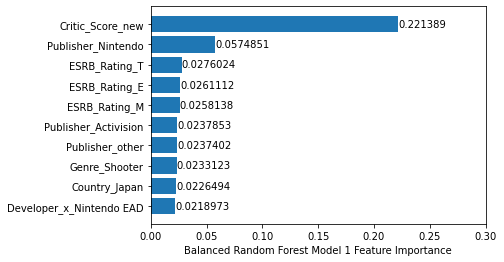

In [124]:
sorted_idx = brf_model_1.feature_importances_.argsort()[-10:]
x = X.columns[sorted_idx]
y = brf_model_1.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Balanced Random Forest Model 1 Feature Importance")
plt.xlim(0.0,0.3)

## Easy Ensemble AdaBoost Classifier Model

In [125]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier 

eec_model = EasyEnsembleClassifier(n_estimators=128, random_state=78)

eec_model_1 = eec_model.fit(X_train, y_train)

In [126]:
# Calculated the balanced accuracy score
y_pred_eec = eec_model_1.predict(X_test)

eec_acc_score = balanced_accuracy_score(y_test, y_pred_eec)

In [127]:
cm_eec = confusion_matrix(y_test, y_pred_eec)

# Create a DataFrame from the confusion matrix.
cm_eec_df = pd.DataFrame(
    cm_eec, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

cm_eec_df

,Predicted high,Predicted low,Predicted medium
Actual high,8,0,4
Actual low,55,1184,425
Actual medium,47,119,235


In [128]:
# Print the imbalanced classification report
print('Model: EasyEnsembleClassifier')
print("---------------------")
print(f"Accuracy Score : {eec_acc_score}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred_eec))

Model: EasyEnsembleClassifier
---------------------
Accuracy Score : 0.6547466803077776
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.07      0.67      0.95      0.13      0.80      0.62        12
        low       0.91      0.71      0.71      0.80      0.71      0.51      1664
     medium       0.35      0.59      0.74      0.44      0.66      0.43       401

avg / total       0.80      0.69      0.72      0.73      0.70      0.49      2077



# Dataframe 2: No 'Country' columns
row count after dropping NaNs = 11293

In [129]:
# Drop 'Country' column 
no_country_df = games_df.drop(['Country', 'Total_Sales'], axis=1).dropna()
print(no_country_df.shape)
no_country_df.head()

(11293, 7)


,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score_new,Total_Sales_Class
0,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,high
2,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,high
4,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,high
5,Role-Playing,E,GB,Nintendo,Game Freak,9.4,high
6,Platform,E,DS,Nintendo,Nintendo EAD,9.1,high


In [130]:
# Check unique values
no_country_df.nunique()

Genre                  20
ESRB_Rating             6
Platform               30
Publisher             320
Developer_x          1078
Critic_Score_new      387
Total_Sales_Class       3
dtype: int64

In [131]:
# Keep top 14 of Genre
top = no_country_df.Genre.value_counts().index[0:14]
no_country_df.Genre = np.where(no_country_df.Genre.isin(top), no_country_df.Genre,'other')

In [132]:
# Keep top 18 of Platform
top = no_country_df.Platform.value_counts().index[0:18]
no_country_df.Platform = np.where(no_country_df.Platform.isin(top), no_country_df.Platform,'other')

In [133]:
# Keep top 15 of Publisher
top = no_country_df.Publisher.value_counts().index[0:15]
no_country_df.Publisher = np.where(no_country_df.Publisher.isin(top), no_country_df.Publisher, 'other')

In [134]:
# Keep top 15 of Developer_x
top = no_country_df.Developer_x.value_counts().index[0:15]
no_country_df.Developer_x = np.where(no_country_df.Developer_x.isin(top), no_country_df.Developer_x,'other')

In [135]:
# Assign features
X2 = no_country_df.drop('Total_Sales_Class', axis = 1)
X2

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score_new
0,Sports,E,Wii,Nintendo,Nintendo EAD,7.700000
2,Racing,E,Wii,Nintendo,Nintendo EAD,8.200000
4,Sports,E,Wii,Nintendo,Nintendo EAD,8.000000
5,Role-Playing,E,other,Nintendo,other,9.400000
6,Platform,E,DS,Nintendo,Nintendo EAD,9.100000
...,...,...,...,...,...,...
19823,Adventure,E10,PC,other,other,6.600000
19838,Strategy,T,PC,Sega,other,7.692857
19840,Misc,E10,PS4,other,other,7.000000
19856,Platform,E,3DS,Nintendo,other,7.200000


In [136]:
# Encoding object dtype columns
X2_cat = X2.select_dtypes(include='object')
X2_cat = list(X2_cat.columns)
X2_cat

['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer_x']

In [137]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df2 = pd.DataFrame(enc.fit_transform(X2[X2_cat]))

# Add the encoded variable names to the dataframe
encode_df2.columns = enc.get_feature_names(X2_cat)

encode_df2

/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,...,Developer_x_Omega Force,Developer_x_Square Enix,Developer_x_THQ,Developer_x_Traveller's Tales,Developer_x_Ubisoft,Developer_x_Ubisoft Montreal,Developer_x_Unknown,Developer_x_Vicarious Visions,Developer_x_Visual Concepts,Developer_x_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11288,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11290,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11291,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [138]:
# Reset X dataframe index to merge with encode_df
X2.reset_index(drop=True, inplace=True)
X2

,Genre,ESRB_Rating,Platform,Publisher,Developer_x,Critic_Score_new
0,Sports,E,Wii,Nintendo,Nintendo EAD,7.700000
1,Racing,E,Wii,Nintendo,Nintendo EAD,8.200000
2,Sports,E,Wii,Nintendo,Nintendo EAD,8.000000
3,Role-Playing,E,other,Nintendo,other,9.400000
4,Platform,E,DS,Nintendo,Nintendo EAD,9.100000
...,...,...,...,...,...,...
11288,Adventure,E10,PC,other,other,6.600000
11289,Strategy,T,PC,Sega,other,7.692857
11290,Misc,E10,PS4,other,other,7.000000
11291,Platform,E,3DS,Nintendo,other,7.200000


In [139]:
# Merge one-hot encoded features and drop the originals
X2 = X2.merge(encode_df2, left_index=True, right_index=True)
X2 = X2.drop(X2_cat, 1)
X2

/var/folders/gd/1878fbxd5zs899fs6znx1h_40000gn/T/ipykernel_12611/3251958379.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X2 = X2.drop(X2_cat, 1)


,Critic_Score_new,Genre_Action,Genre_Action-Adventure,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Music,Genre_Platform,Genre_Puzzle,Genre_Racing,...,Developer_x_Omega Force,Developer_x_Square Enix,Developer_x_THQ,Developer_x_Traveller's Tales,Developer_x_Ubisoft,Developer_x_Ubisoft Montreal,Developer_x_Unknown,Developer_x_Vicarious Visions,Developer_x_Visual Concepts,Developer_x_other
0,7.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,9.100000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11288,6.600000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11289,7.692857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11290,7.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11291,7.200000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Train and fit the model with input data from dataframe 2

In [140]:
# Assign the target
y2 = no_country_df['Total_Sales_Class']
y2.value_counts()

low       9293
medium    1920
high        80
Name: Total_Sales_Class, dtype: int64

In [141]:
print(X2.shape)
print(y2.shape)

(11293, 73)
(11293,)


In [142]:
# Split data to training and testing set
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=1)

# Check the balance of the target variables.
print(f"y2_train: {Counter(y2_train)}")
print(f"y2_test: {Counter(y2_test)}")

y2_train: Counter({'low': 6995, 'medium': 1416, 'high': 58})
y2_test: Counter({'low': 2298, 'medium': 504, 'high': 22})


In [143]:
# Creating a StandardScaler instance.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X2_scaler = scaler.fit(X2_train)

# Scaling the data.
X2_train_scaled = X2_scaler.transform(X2_train)
X2_test_scaled = X2_scaler.transform(X2_test)

In [144]:
# Fitting the random forest classifier model
rf_model_2 = rf_model.fit(X2_train_scaled, y2_train)
# Making predictions using the testing data.
y2_pred_rf = rf_model_2.predict(X2_test_scaled)
acc_score_2 = accuracy_score(y2_test, y2_pred_rf)

In [145]:
cm2 = confusion_matrix(y2_test, y2_pred_rf)

# Create a DataFrame from the confusion matrix.
cm2_df = pd.DataFrame(
    cm2, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

In [146]:
print('Model: Random Forest Classifier 2 (with feature engineering)')
print("---------------------")
print("Confusion Matrix")
display(cm2_df)
print("---------------------")
print(f"Accuracy Score : {acc_score_2}")
print("---------------------")
print("Classification Report")
print(classification_report(y2_test, y2_pred_rf))

Model: Random Forest Classifier 2 (with feature engineering)
---------------------
Confusion Matrix


,Predicted high,Predicted low,Predicted medium
Actual high,4,5,13
Actual low,2,2158,138
Actual medium,4,281,219


---------------------
Accuracy Score : 0.8431303116147308
---------------------
Classification Report
              precision    recall  f1-score   support

        high       0.40      0.18      0.25        22
         low       0.88      0.94      0.91      2298
      medium       0.59      0.43      0.50       504

    accuracy                           0.84      2824
   macro avg       0.62      0.52      0.55      2824
weighted avg       0.83      0.84      0.83      2824



In [147]:
# Calculate feature importance
print("Feature Importance: rf model 2")
sorted(zip(rf_model_2.feature_importances_, X2.columns), reverse=True)

Feature Importance: rf model 2


[(0.40833990761781824, 'Critic_Score_new'),
 (0.03616262309227477, 'Publisher_Nintendo'),
 (0.018513552905231188, 'Platform_PS2'),
 (0.017335502113502228, 'Publisher_other'),
 (0.01711042031833665, 'Platform_PS3'),
 (0.01674602364291348, 'Genre_Action'),
 (0.016581409054014205, 'ESRB_Rating_T'),
 (0.016360074000229752, 'ESRB_Rating_E'),
 (0.015930638852264915, 'Platform_X360'),
 (0.015898081025649477, 'Genre_Role-Playing'),
 (0.01492436504902807, 'Platform_PC'),
 (0.014313890538615391, 'Platform_PS4'),
 (0.014272041548773887, 'Platform_Wii'),
 (0.013824824500879313, 'ESRB_Rating_E10'),
 (0.013644420030050545, 'Platform_PS'),
 (0.013312573788134724, 'Genre_Platform'),
 (0.013254500781765958, 'Genre_Racing'),
 (0.013148559926285993, 'Genre_Shooter'),
 (0.013081154312879834, 'Genre_Sports'),
 (0.012922774446881885, 'Developer_x_other'),
 (0.012051062908626467, 'ESRB_Rating_M'),
 (0.011473644616359897, 'Genre_Misc'),
 (0.011271748636993793, 'Platform_DS'),
 (0.01063778351600251, 'Publisher

(0.0, 0.45)

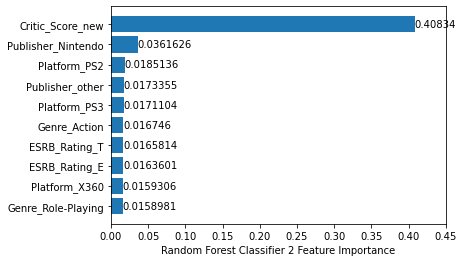

In [148]:
sorted_idx = rf_model_2.feature_importances_.argsort()[-10:]
x = X2.columns[sorted_idx]
y = rf_model_2.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Random Forest Classifier 2 Feature Importance")
plt.xlim(0.0,0.45)

In [149]:
# Fitting the BalancedRandomForestClassifier model
brf_model_2 = brf_model.fit(X2_train, y2_train)
y2_pred_brf = brf_model_2.predict(X2_test)

brf_acc_score_2 = balanced_accuracy_score(y2_test, y2_pred_brf)

In [152]:
cm2_brf = confusion_matrix(y2_test, y2_pred_brf)

# Create a DataFrame from the confusion matrix.
cm2_brf_df = pd.DataFrame(
    cm2_brf, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

In [151]:
# Print the imbalanced classification report
print('Model: Balanced Random Forest Classifier 2')
print("---------------------")
print("Confusion Matrix")
display(cm2_brf_df)
print("---------------------")
print(f"Accuracy Score : {brf_acc_score_2}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y2_test, y2_pred_brf))

Model: Balanced Random Forest Classifier 2
---------------------
Confusion Matrix


,Predicted high,Predicted low,Predicted medium
Actual high,19,2,1
Actual low,109,1750,439
Actual medium,119,163,222


---------------------
Accuracy Score : 0.6885481069554177
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.08      0.86      0.92      0.14      0.89      0.79        22
        low       0.91      0.76      0.69      0.83      0.72      0.53      2298
     medium       0.34      0.44      0.81      0.38      0.60      0.34       504

avg / total       0.80      0.71      0.71      0.75      0.70      0.50      2824



In [154]:
# Calculate feature importance
print("Feature Importance: brf model 2")
sorted(zip(brf_model_2.feature_importances_, X2.columns), reverse=True)

Feature Importance: brf model 2


[(0.26506435769556785, 'Critic_Score_new'),
 (0.07252626741415412, 'Publisher_Nintendo'),
 (0.029106079156432624, 'Publisher_other'),
 (0.02864006278592584, 'ESRB_Rating_T'),
 (0.024569731581915052, 'ESRB_Rating_E'),
 (0.022907571225025954, 'Developer_x_Nintendo EAD'),
 (0.02121092836772456, 'Genre_Shooter'),
 (0.02059009975535625, 'Developer_x_other'),
 (0.020392498139668817, 'Genre_Action'),
 (0.019340415006377846, 'Publisher_Activision'),
 (0.01898239620297274, 'ESRB_Rating_M'),
 (0.017809958629492147, 'Genre_Platform'),
 (0.0169948987111945, 'Genre_Role-Playing'),
 (0.015624224911756362, 'Platform_PC'),
 (0.015460919396540686, 'Genre_Sports'),
 (0.015442598539561926, 'Platform_PS4'),
 (0.01542824051161645, 'Platform_X360'),
 (0.015124921488696796, 'Platform_PS2'),
 (0.014769310850871962, 'Publisher_Electronic Arts'),
 (0.014600865046883243, 'Platform_PS3'),
 (0.014252792647376073, 'Platform_Wii'),
 (0.013963709485265994, 'Genre_Racing'),
 (0.013909712502233374, 'ESRB_Rating_E10'),


(0.0, 0.4)

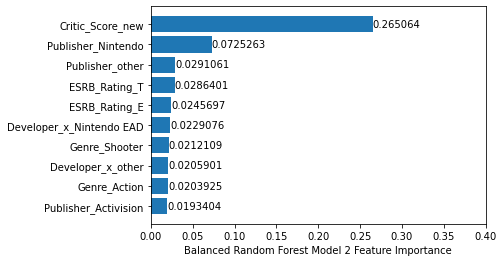

In [155]:
sorted_idx = brf_model_2.feature_importances_.argsort()[-10:]
x = X2.columns[sorted_idx]
y = brf_model_2.feature_importances_[sorted_idx]

fig, ax = plt.subplots()
bars = ax.barh(x, y)
ax.bar_label(bars)
plt.xlabel("Balanced Random Forest Model 2 Feature Importance")
plt.xlim(0.0,0.4)

In [156]:
# Fitting the EasyEnsembleClassifier model
eec_model_2 = eec_model.fit(X2_train, y2_train)
y2_pred_eec = eec_model_2.predict(X2_test)

eec_acc_score_2 = balanced_accuracy_score(y2_test, y2_pred_eec)

In [159]:
cm2_eec = confusion_matrix(y2_test, y2_pred_eec)

# Create a DataFrame from the confusion matrix.
cm2_eec_df = pd.DataFrame(
    cm2_eec, index=["Actual high", "Actual low", "Actual medium"], columns=["Predicted high", "Predicted low", "Predicted medium"])

In [158]:
# Print the imbalanced classification report
print('Model: EasyEnsembleClassifier 2')
print("---------------------")
print("Confusion Matrix")
display(cm2_eec_df)
print("---------------------")
print(f"Accuracy Score : {eec_acc_score_2}")
print("---------------------")
print("Classification Report")
print(classification_report_imbalanced(y2_test, y2_pred_eec))

Model: EasyEnsembleClassifier 2
---------------------
Confusion Matrix


,Predicted high,Predicted low,Predicted medium
Actual high,14,1,7
Actual low,57,1363,878
Actual medium,75,104,325


---------------------
Accuracy Score : 0.6247764540845481
---------------------
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

       high       0.10      0.64      0.95      0.17      0.78      0.59        22
        low       0.93      0.59      0.80      0.72      0.69      0.46      2298
     medium       0.27      0.64      0.62      0.38      0.63      0.40       504

avg / total       0.80      0.60      0.77      0.66      0.68      0.45      2824

